In [1]:
from pathlib import Path
from time import time
import datetime

import numpy as np
import pandas as pd

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
# Global Settings

# Directories
model_dataDir = 'DATA/MODELDATA/'
bench_dataDir = 'DATA/COINHISTDATA/'


# Time
START = 2020
END = 2022


# Helpers
sns.set_style('whitegrid')
np.random.seed(42)
idx = pd.IndexSlice


In [3]:
# Import Data

# Predictions
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')
lasso_predictions = pd.read_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')

# Prices
model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
model_mdf.set_index(['Dates', 'Coin'], inplace=True)
prices = model_mdf.loc[:,'Open':'Close']

# Benchmark
bench = pd.read_csv(bench_dataDir + 'bitcoin.csv')
bench.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
bench.set_index('Dates', inplace=True)
bench = bench.loc[:, ['Open']]
#bench = bench.Open
bench = bench.pct_change()
bench = bench.loc[str(START):]
bench.rename(columns = {'Open':'Bench'}, inplace = True)
print(bench.head())


               Bench
Dates               
2020-01-01 -0.004841
2020-01-02 -0.010226
2020-01-03  0.008102
2020-01-04  0.017150
2020-01-05  0.017537


In [4]:
lr_predictions.tail()

,,actuals,predicted
Dates,Coin,,
2020-02-22,ripple,-0.012109,-0.002698
2020-02-23,ripple,-0.020270,0.021145
2020-02-24,ripple,-0.094959,0.023718
2020-02-25,ripple,-0.051931,0.057448
2020-02-26,ripple,0.039387,0.028220


In [5]:
ridge_predictions.tail()

,,actuals,predicted,alpha
Dates,Coin,,,
2020-02-22,ripple,-0.012109,-0.000029,50000.0
2020-02-23,ripple,-0.020270,-0.000005,50000.0
2020-02-24,ripple,-0.094959,0.000006,50000.0
2020-02-25,ripple,-0.051931,0.000019,50000.0
2020-02-26,ripple,0.039387,-0.000014,50000.0


In [6]:
lasso_predictions.tail()

,,actuals,predicted,alpha
Dates,Coin,,,
2020-02-22,ripple,-0.012109,0.0,10.0
2020-02-23,ripple,-0.020270,0.0,10.0
2020-02-24,ripple,-0.094959,0.0,10.0
2020-02-25,ripple,-0.051931,0.0,10.0
2020-02-26,ripple,0.039387,0.0,10.0


In [7]:
bench = bench.iloc[::-1]
bench.tail()

,Bench
Dates,
2020-01-05,0.017537
2020-01-04,0.017150
2020-01-03,0.008102
2020-01-02,-0.010226
2020-01-01,-0.004841


In [8]:
def filterdata(mdf,START):
    '''
    :param mdf: A MultiIndex DataFrame
    :param START: A start year as integer
    :return: MultiIndex Dataframe filtered by the above
    '''
    filtered = []
    for coin, new_df in mdf.groupby(level=1):
        new_df['Coin'] = new_df.index.get_level_values('Coin')
        new_df['Dates'] = new_df.index.get_level_values('Dates')
        new_df.set_index(new_df.index.get_level_values('Dates'), inplace=True)
        new_df = new_df.loc[str(START):]
        new_df.set_index(['Dates', 'Coin'], inplace=True)

        #print(new_df)
        filtered.append(new_df)

    mdf = pd.concat(filtered)
    mdf.sort_index(inplace=True)

    return mdf


In [9]:
prices = filterdata(prices,START) 
prices = prices.iloc[::-1]
prices = prices.swaplevel()
prices.tail()

,,Open,High,Low,Close
Coin,Dates,,,,
ripple,2020-01-01,0.192967,0.193844,0.190681,0.190681
ethereum,2020-01-01,130.069420,132.338664,128.819361,128.819361
cardano,2020-01-01,0.032962,0.033692,0.032957,0.032957
bitcoin,2020-01-01,7212.799217,7235.438382,7118.483482,7118.483482
binancecoin,2020-01-01,13.789327,13.816538,13.499053,13.499053


In [10]:
def get_backtest_data(predictions, prices):
    """Combine regression model predictions
        with  OHLCV data"""
    
    best_alpha = predictions.groupby('alpha').apply(lambda x: spearmanr(x.actuals, x.predicted)[0]).idxmax()
    predictions = predictions[predictions.alpha == best_alpha]
    tickers = predictions.index.get_level_values('Coin').unique()
    
    start = predictions.index.get_level_values('Dates').min().strftime('%Y-%m-%d')
    stop = (predictions.index.get_level_values('Dates').max() + pd.DateOffset(1)).strftime('%Y-%m-%d')
    idx = pd.IndexSlice
    #prices = prices.sort_index().loc[idx[tickers, start:stop], :]
    predictions = predictions.loc[predictions.alpha == best_alpha, ['predicted']]

    print(predictions.head())
    print(predictions.tail())

    print('-----------------')
    prices = prices.sort_index()
    print(prices.head())
    
    mdf = predictions.join(prices)

    
    return mdf


data = get_backtest_data(lasso_predictions,prices)
print(data.info())

                        predicted
Dates      Coin                  
2022-02-10 binancecoin   0.000519
2022-02-11 binancecoin   0.002130
2022-02-12 binancecoin   0.002284
2022-02-13 binancecoin   0.000998
2022-02-14 binancecoin  -0.000307
                   predicted
Dates      Coin             
2020-02-22 ripple  -0.000232
2020-02-23 ripple  -0.000212
2020-02-24 ripple  -0.000114
2020-02-25 ripple   0.000261
2020-02-26 ripple   0.000453
-----------------
                             Open       High        Low      Close
Coin        Dates                                                 
binancecoin 2020-01-01  13.789327  13.816538  13.499053  13.499053
            2020-01-02  13.522027  13.537388  12.978777  13.161944
            2020-01-03  13.579740  13.676754  13.481308  13.657714
            2020-01-04  13.650140  14.000923  13.630318  14.000923
            2020-01-05  13.972162  14.400672  13.958858  14.390606
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3640 entries, (Timesta

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [11]:
#data['predicted'].nan().sum()

In [12]:
data.head(100)

,,predicted,Open,High,Low,Close
Dates,Coin,,,,,
2022-02-10,binancecoin,0.000519,418.365077,428.371691,411.693474,413.351061
2022-02-11,binancecoin,0.002130,412.164176,418.259585,394.111397,401.038840
2022-02-12,binancecoin,0.002284,400.720734,406.140468,397.057258,405.139396
2022-02-13,binancecoin,0.000998,403.370747,405.923170,392.329648,394.188024
2022-02-14,binancecoin,-0.000307,394.450842,413.341112,392.852317,413.093381
...,...,...,...,...,...,...
2022-01-31,ethereum,0.004322,2505.116856,2754.698330,2505.116856,2754.698330
2022-02-01,ethereum,0.000761,2742.845029,2798.795680,2736.673444,2787.249311
2022-02-02,ethereum,0.001969,2768.979574,2807.733210,2645.921125,2667.728471


In [13]:
#data = data.swaplevel()
data.tail()

,,predicted,Open,High,Low,Close
Dates,Coin,,,,,
2020-02-22,ripple,-0.000232,0.272334,0.278435,0.271762,0.278435
2020-02-23,ripple,-0.000212,0.278555,0.282839,0.275064,0.275064
2020-02-24,ripple,-0.000114,0.275170,0.275560,0.268456,0.269488
2020-02-25,ripple,0.000261,0.269034,0.269034,0.243898,0.243898
2020-02-26,ripple,0.000453,0.245735,0.246377,0.229641,0.231232


In [14]:
# Daily returns for all the coins in the dataset for the target time period
daily_returns = data.Open.unstack('Coin').sort_index().pct_change()
daily_returns.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 728 entries, 2020-02-20 to 2022-02-16
Columns: 5 entries, binancecoin to ripple
dtypes: float64(5)
memory usage: 34.1 KB


In [15]:
# Compute forward returns
fwd_returns = daily_returns.shift(-1)
fwd_returns.tail()

Coin,binancecoin,bitcoin,cardano,ethereum,ripple
Dates,,,,,
2022-02-12,0.006613,-0.001795,-0.031783,-0.007141,0.061532
2022-02-13,-0.022113,-0.006371,-0.014000,-0.017688,-0.032911
2022-02-14,0.055515,0.036222,0.034955,0.051900,0.033808
2022-02-15,0.033178,0.009140,0.017304,0.035776,0.012595
2022-02-16,NaN,NaN,NaN,NaN,NaN


In [16]:
# Isolate the predictions
predictions = data.predicted.unstack('Coin')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 728 entries, 2020-02-20 to 2022-02-16
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   binancecoin  728 non-null    float64
 1   bitcoin      728 non-null    float64
 2   cardano      728 non-null    float64
 3   ethereum     728 non-null    float64
 4   ripple       728 non-null    float64
dtypes: float64(5)
memory usage: 34.1 KB


In [17]:
#predictions.head(50)

In [24]:
# VECTORIZED BACKTEST

# Set the number of long and short positions
# Change this to something that makes sense commensurate with the number of coins in the pool
N_LONG = N_SHORT = 2

# Get the trading signals from the model predictions
long_signals = ((predictions
                .where(predictions > 0)
                .rank(axis=1, ascending=False) > N_LONG)
                .astype(int))
short_signals = ((predictions
                  .where(predictions < 0)
                  .rank(axis=1) > N_SHORT)
                 .astype(int))


# Compute the portfolio returns for the backtest
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

In [25]:
#strategy.join(bench).head(100)

In [26]:
strategy.tail()

,Strategy
Dates,
2022-02-12,0.010519
2022-02-13,-0.003538
2022-02-14,-0.018348
2022-02-15,-0.013791
2022-02-16,NaN


In [27]:
bench = bench.iloc[::-1]
bench.tail()

,Bench
Dates,
2020-01-05,0.017537
2020-01-04,0.017150
2020-01-03,0.008102
2020-01-02,-0.010226
2020-01-01,-0.004841


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


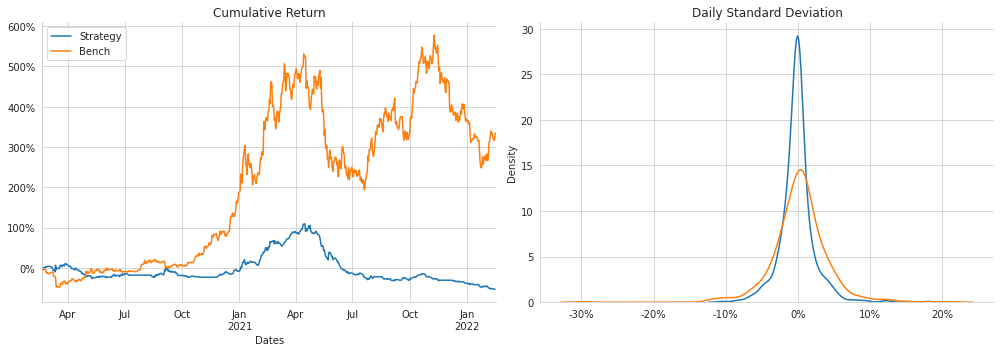

In [28]:
# Results
bench.index = pd.to_datetime(bench.index)
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(bench).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(bench, ax=axes[1], hist=False, label='BTC')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

In [23]:
# EVENT-DRIVEN BACKTEST with Backtestester